### **Coursera Review Dataset - Dataset 2**

Install necessary libraries

In [ ]:
!pip install -q transformers datasets langid contractions wordcloud torch bertviz
!pip install -q nltk

In [ ]:
import nltk
import torch
import re
import contractions
import langid
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from datasets import Dataset
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, cohen_kappa_score, matthews_corrcoef
)
plt.style.use('ggplot')

In [ ]:
#Downloading NLTK resources
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Data Collection

In [ ]:
#load dataset
review = pd.read_csv("/content/reviews.csv")

In [ ]:
#check data size
original_len = len(review)
print(original_len)

107018


In [ ]:
#converting dataset into dataframe
data = pd.DataFrame(review)
print(data.head())
print(data.shape)

   Id                                             Review  Label
0   0                               good and interesting      5
1   1  This class is very helpful to me. Currently, I...      5
2   2  like!Prof and TAs are helpful and the discussi...      5
3   3  Easy to follow and includes a lot basic and im...      5
4   4  Really nice teacher!I could got the point eazl...      4
(107018, 3)


In [ ]:
#change column name
data.rename(columns={'Label':'Rating'}, inplace=True)

In [ ]:
data.columns

Index(['Id', 'Review', 'Rating'], dtype='object')

# Data Preprocessing

In [ ]:
#checking nulls
data.isnull().sum()

,0
Id,0
Review,0
Rating,0


In [ ]:
#Check class distribution before preprocessing
data['Rating'].value_counts(normalize=False).sort_index()

,count
Rating,
1,2469
2,2251
3,5071
4,18054
5,79173


In [ ]:
#Review lengths
data['Review_len'] = data['Review'].str.len()
data['Review_len'].describe()
print("Minimum review length:", data['Review_len'].min())
print("Maximum review length:", data['Review_len'].max())

Minimum review length: 1
Maximum review length: 7766


In [ ]:
#Remove duplicates based on text and review
data = data.drop_duplicates(subset=["Review","Rating"], keep="first")
print("Shape after removing duplicates:", data.shape)

Shape after removing duplicates: (100472, 4)


In [ ]:
#Remove extremely short reviews (keep text length >= 3)
data = data[data['Review_len'] >= 3]
print("Shape after removing very short reviews:", data.shape)

Shape after removing very short reviews: (100465, 4)


In [ ]:
#Detect language of each review using langid
!pip install langid
import langid
#Create a new column with language code
data['lang'] = data['Review'].apply(lambda x: langid.classify(x)[0])
#Check distribution of languages
data['lang'].value_counts().head()

,count
lang,
en,99171
it,215
de,183
es,175
fr,156


In [ ]:
#Keep only English reviews
data = data[data['lang'] == 'en']
print("Shape after keeping only English reviews:", data.shape)
#Drop the 'lang' column
data = data.drop(columns=['lang'])

Shape after keeping only English reviews: (99171, 5)


In [ ]:
#Final class distribution
data['Rating'].value_counts().sort_index()

,count
Rating,
1,2382
2,2209
3,4984
4,17398
5,72198


In [ ]:
#remove id column
data.drop(columns="Id", inplace=True)

In [ ]:
#Summary of preprocessing
summary = {
    "Total Reviews After Preprocessing": [len(data)],
    "Duplicates Removed": [len(data) - len(data.drop_duplicates(subset="Review", keep="first"))],
}
pd.DataFrame(summary)

,Total Reviews After Preprocessing,Duplicates Removed
0,99171,414


# Exploratory Data Analysis

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99171 entries, 0 to 107017
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Review      99171 non-null  object
 1   Rating      99171 non-null  int64 
 2   Review_len  99171 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.0+ MB


In [ ]:
#basic statistics
data.describe()

,Rating,Review_len
count,99171.000000,99171.000000
mean,4.561152,156.027266
std,0.876732,192.259708
min,1.000000,3.000000
25%,4.000000,52.000000
50%,5.000000,98.000000
75%,5.000000,190.000000
max,5.000000,7766.000000


In [ ]:
data.head(10)

,Review,Rating,Review_len
0,good and interesting,5,20
1,"This class is very helpful to me. Currently, I...",5,121
2,like!Prof and TAs are helpful and the discussi...,5,117
3,Easy to follow and includes a lot basic and im...,5,81
4,Really nice teacher!I could got the point eazl...,4,58
5,"Great course - I recommend it for all, especia...",5,75
6,One of the most useful course on IT Management!,5,47
7,I was disappointed because the name is mislead...,3,381
8,Super content. I'll definitely re-do the course,5,47
9,One of the excellent courses at Coursera for i...,5,88


In [ ]:
data['Review_len'] = data['Review'].str.split().str.len()
#Rating distribution
print(data['Rating'].value_counts(normalize=True))

Rating
5    0.728015
4    0.175434
3    0.050257
1    0.024019
2    0.022275
Name: proportion, dtype: float64


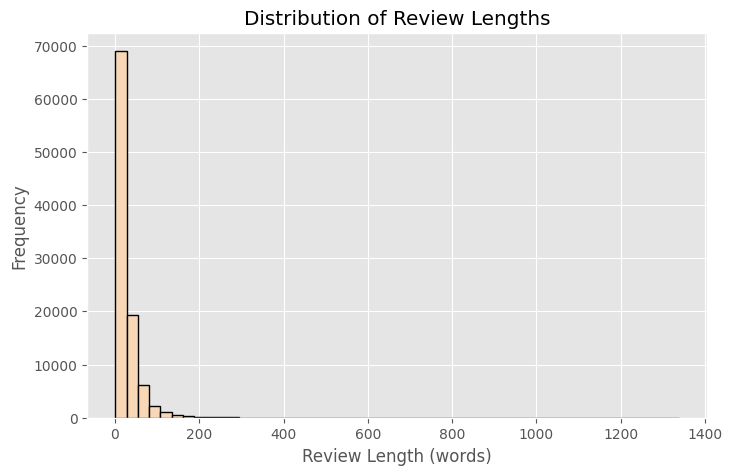

In [ ]:
#histogram plot of review length distribution
plt.figure(figsize=(8,5))
plt.hist(
    data['Review_len'],
    bins=50,
    color="#f7d7b5",
    edgecolor = 'black',     # <-- pastel blue
    linewidth=1
)
plt.xlabel("Review Length (words)")
plt.ylabel("Frequency")
plt.title("Distribution of Review Lengths")
plt.show()

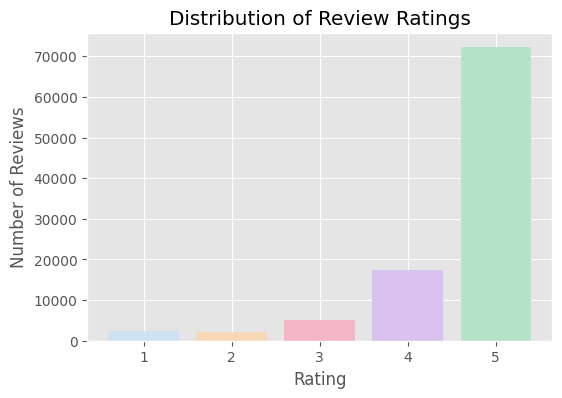

In [ ]:
#Bar plot of rating frequencies
pastel_colors = ["#cfe2f3", "#f7d7b5", "#f4b6c2", "#d9c2f0", "#b5e3c8"]
plt.figure(figsize=(6,4))
plt.bar(
    data['Rating'].value_counts().sort_index().index,
    data['Rating'].value_counts().sort_index().values,
    color=pastel_colors[:len(data['Rating'].unique())],
    linewidth=1
)
plt.xlabel("Rating")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Review Ratings")
plt.show()

In [ ]:
#review length by label
data.groupby('Rating')['Review_len'].describe()

,count,mean,std,min,25%,50%,75%,max
Rating,,,,,,,,
1,2382.0,50.641898,61.136381,1.0,14.0,30.0,62.0,571.0
2,2209.0,54.590312,65.186988,1.0,16.0,33.0,69.0,857.0
3,4984.0,41.017055,52.123800,1.0,13.0,25.0,50.0,1041.0
4,17398.0,29.400506,36.013005,1.0,10.0,19.0,37.0,1338.0
5,72198.0,23.074393,25.941274,1.0,8.0,15.0,29.0,1193.0


In [ ]:
#detecting extreme cases
#Very short reviews (≥3 but <10 chars)
data[data['Review_len'] < 10].head()

,Review,Rating,Review_len
0,good and interesting,5,3
6,One of the most useful course on IT Management!,5,9
8,Super content. I'll definitely re-do the course,5,7
11,Excellent course and teachers. Congratulations!!,5,5
14,Very structured approach. Thank you for sharin...,5,9


In [ ]:
#Very long reviews (>1000 chars)
data[data['Review_len'] > 1000].head()

,Review,Rating,Review_len
330,This is my feedback as a Beta-Tester for the c...,4,1338
6607,(I posted this review in a blog [https://guhya...,3,1041
10697,This is a great course and a daring venture fo...,4,1098
10818,"I will try now a Summary of the whole course, ...",5,1193


# LIGHT TEXT PREPROCESSING FOR DISTILBERT

In [ ]:
#Initialize preprocessing tools
def clean_text(text):
    text = text.lower()
    text = contractions.fix(text)
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

data["Clean_Review"] = data["Review"].apply(clean_text)

In [ ]:
#Original vs Cleaned
data[['Review','Clean_Review']].sample(5)

,Review,Clean_Review
60345,"Great course, very accesible for all, experts ...","great course, very accesible for all, experts ..."
70709,Very sad that this is no longer free,very sad that this is no longer free
40067,"Interesting Course, I learnt a lot.","interesting course, i learnt a lot."
53762,Perfect course on Machine Learning. Challengin...,perfect course on machine learning. challengin...
39687,helped me to learn a lot about internet security,helped me to learn a lot about internet security


# Text Mining

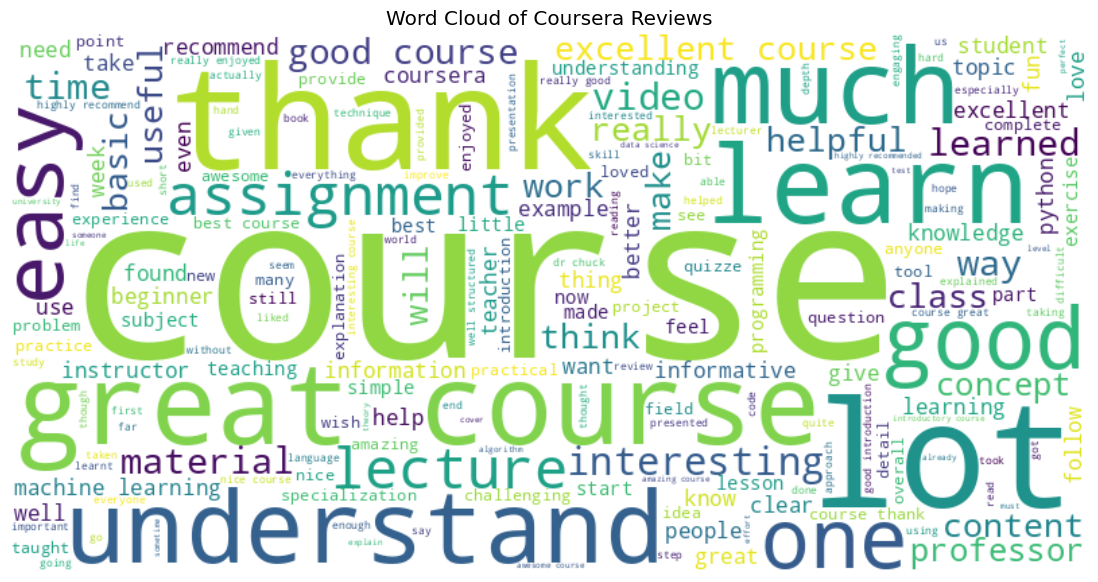

In [ ]:
#Generate original-style word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white'
).generate(' '.join(data['Clean_Review']))

plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Coursera Reviews")
plt.show()


# Star ratings were converted into sentiment

In [ ]:
def label_sentiment(rating):
    if rating <= 2:
      return 0   # negative
    elif rating == 3:
      return 1   # neutral
    else:
      return 2   # positive

data["label"] = data["Rating"].apply(label_sentiment)
data["label"].value_counts()

,count
label,
2,89596
1,4984
0,4591


In [ ]:
from sklearn.model_selection import train_test_split
#TRAIN–TEST SPLIT 80:20
train_df, test_df = train_test_split(
    data[["Clean_Review", "label"]],
    test_size=0.2,
    random_state=42,
    stratify=data["label"]
)

In [ ]:
#Save test set for SHAP in Jupyter
test_df.to_csv("/content/test_reviews.csv", index=False)

BERT sentiment classifier

In [ ]:
#LOAD DistilBERT TOKENIZER (Faster)
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
def encode_batch(batch):
    return tokenizer(
        batch["Clean_Review"],
        padding="max_length",
        truncation=True,
        max_length=64
    )

train_dataset = Dataset.from_pandas(train_df)
test_dataset  = Dataset.from_pandas(test_df)

train_dataset = train_dataset.map(encode_batch, batched=True)
test_dataset  = test_dataset.map(encode_batch, batched=True)

train_dataset = train_dataset.rename_column("label", "labels")
test_dataset  = test_dataset.rename_column("label", "labels")

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/79336 [00:00<?, ? examples/s]

Map:   0%|          | 0/19835 [00:00<?, ? examples/s]

In [ ]:
#LOAD DistilBERT MODEL 3 classes → negative, neutral, positive.
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=3
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="/content/model_results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    report_to="none"
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.177600,0.198477
2,0.123700,0.198794


TrainOutput(global_step=9918, training_loss=0.17509599675764886, metrics={'train_runtime': 1027.9562, 'train_samples_per_second': 154.357, 'train_steps_per_second': 9.648, 'total_flos': 2627405240150016.0, 'train_loss': 0.17509599675764886, 'epoch': 2.0})

In [ ]:
trainer.save_model("/content/distilbert_sentiment_model")
tokenizer.save_pretrained("/content/distilbert_sentiment_model")

('/content/distilbert_sentiment_model/tokenizer_config.json',
 '/content/distilbert_sentiment_model/special_tokens_map.json',
 '/content/distilbert_sentiment_model/vocab.txt',
 '/content/distilbert_sentiment_model/added_tokens.json',
 '/content/distilbert_sentiment_model/tokenizer.json')

In [ ]:
#Download the Trained Model to the PC for further shap analysis in jupyter
!zip -r distilbert_sentiment_model.zip /content/distilbert_sentiment_model

  adding: content/distilbert_sentiment_model/ (stored 0%)
  adding: content/distilbert_sentiment_model/training_args.bin (deflated 53%)
  adding: content/distilbert_sentiment_model/model.safetensors (deflated 8%)
  adding: content/distilbert_sentiment_model/special_tokens_map.json (deflated 42%)
  adding: content/distilbert_sentiment_model/tokenizer.json (deflated 71%)
  adding: content/distilbert_sentiment_model/tokenizer_config.json (deflated 75%)
  adding: content/distilbert_sentiment_model/config.json (deflated 49%)
  adding: content/distilbert_sentiment_model/vocab.txt (deflated 53%)


In [ ]:
preds = trainer.predict(test_dataset)
logits = preds.predictions
y_pred = logits.argmax(axis=1)
y_true = preds.label_ids
print(classification_report(
    y_true, y_pred,
    target_names=["negative", "neutral", "positive"]
))

              precision    recall  f1-score   support

    negative       0.72      0.68      0.70       918
     neutral       0.45      0.34      0.39       997
    positive       0.97      0.98      0.97     17920

    accuracy                           0.94     19835
   macro avg       0.71      0.67      0.69     19835
weighted avg       0.93      0.94      0.93     19835



In [ ]:
#calculate performance metrics
accuracy = accuracy_score(y_true, y_pred)
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')
cohens_kappa = cohen_kappa_score(y_true, y_pred)
MCC = matthews_corrcoef(y_true, y_pred)

precision_weighted = precision_score(y_true, y_pred, average='weighted')
recall_weighted = recall_score(y_true, y_pred, average='weighted')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print("=== BERT EVALUATION METRICS ===")
print("Accuracy:", accuracy)
print("Macro Precision:", precision_macro)
print("Macro Recall:", recall_macro)
print("Macro F1:", f1_macro)
print("Cohen's Kappa:", cohens_kappa)
print("MCC:", MCC)
print("Weighted Precision:", precision_weighted)
print("Weighted Recall:", recall_weighted)
print("Weighted F1:", f1_weighted)

=== BERT EVALUATION METRICS ===
Accuracy: 0.9355180236954878
Macro Precision: 0.7132487388803788
Macro Recall: 0.6681174902606201
Macro F1: 0.6879669219685457
Cohen's Kappa: 0.6125956684932169
MCC: 0.6151220082348262
Weighted Precision: 0.9286362620316497
Weighted Recall: 0.9355180236954878
Weighted F1: 0.931615126789065


              precision    recall  f1-score   support

    negative       0.72      0.68      0.70       918
     neutral       0.45      0.34      0.39       997
    positive       0.97      0.98      0.97     17920

    accuracy                           0.94     19835
   macro avg       0.71      0.67      0.69     19835
weighted avg       0.93      0.94      0.93     19835



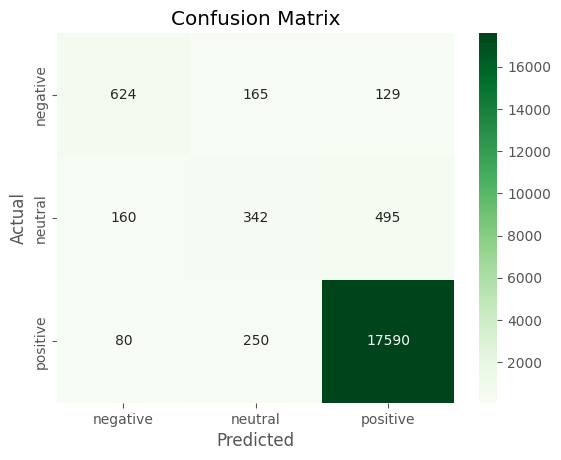

In [ ]:
#classification report for all three classess
print(classification_report(y_true, y_pred, target_names=["negative","neutral","positive"]))

#confusion matrix in heatmap
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt = "d", cmap="Greens",
            xticklabels=["negative","neutral","positive"],
            yticklabels=["negative","neutral","positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()